
# Drone Swarm Simulation Analysis (v3 - Multiple Modulations)

This notebook analyzes the output CSV file generated by the drone swarm simulation, now including data for multiple modulation schemes.<br>


It performs the following steps:
1. **Load Data**: Reads parameters and step-by-step simulation data from the CSV file.<br>
2. **Preprocess Data**:<br>
    - Separates simulation parameters from the main dataset.<br>
    - Converts relevant columns to appropriate numeric types, including multiple capacity columns (e.g., `bpsk_cap`, `qpsk_cap`) and `required_safety_capacity`.<br>
    - Filters for edges that are susceptible to Electronic Warfare (`is_ew_susceptible == True`).<br>
3. **Visualize Data**:<br>
    - For each capacity type (e.g., `theoretical_cap`, `bpsk_cap`, etc.):<br>
        - Plots the capacity of susceptible edges over simulation `steps`.<br>
        - For each plotted edge, a horizontal dashed line indicates its `required_safety_capacity`.<br>
        - Each susceptible edge is represented by a distinct colored line.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io # For reading the mixed-format CSV

In [24]:
sns.set_context("talk")


## 1. Load Data<br>
<br>

In [25]:
# Specify the path to the CSV file generated by the simulation.

csv_filepath = 'swarm_log_detailed_CROSS_ROW_len300_jam2_2624.csv'

In [26]:
def load_simulation_data(filepath):
    """Loads parameters and step data from the simulation CSV file."""
    parameters = {}
    data_lines = []
    with open(filepath, 'r') as f:
        reading_params = True
        header_line = None
        for line_num, line in enumerate(f):
            line = line.strip()
            if not line: # Blank line separates parameters from data header
                reading_params = False
                continue
            if reading_params:
                if ',' in line and not line.startswith('step,'): # Heuristic to avoid header
                    parts = line.split(',', 1)
                    if len(parts) == 2:
                        key, value = parts[0].strip(), parts[1].strip()
                        if value.lower() == 'true':
                            parameters[key] = True
                        elif value.lower() == 'false':
                            parameters[key] = False
                        elif value.startswith('(') and value.endswith(')'):
                            try:
                                parameters[key] = eval(value)
                            except:
                                parameters[key] = value
                        else:
                            try:
                                parameters[key] = float(value)
                            except ValueError:
                                parameters[key] = value
                    elif line_num == 0 and not any(k in line for k in ['step', 'leader_pos_x']):
                         parameters[line] = None
                elif line_num == 0 and not any(k in line for k in ['step', 'leader_pos_x']):
                     parameters[line] = None
            else:
                if header_line is None:
                    header_line = line
                    data_lines.append(header_line)
                else:
                    data_lines.append(line)
    if not data_lines or len(data_lines) < 2:
        raise ValueError("No data or only header found after parameters in the CSV file.")
    data_io = io.StringIO('\n'.join(data_lines))
    df = pd.read_csv(data_io)
    if 'Parameter' in parameters and parameters['Parameter'] == 'Value':
        del parameters['Parameter']
    return parameters, df

Load the data

In [27]:
try:
    sim_params, sim_df = load_simulation_data(csv_filepath)
    print("Simulation Parameters Loaded:")
    for key, value in sim_params.items():
        print(f"  {key}: {value}")
    print("\nFirst 5 rows of Simulation Data:")
    print(sim_df.head())
    print("\nDataframe Info:")
    sim_df.info()
except FileNotFoundError:
    print(f"Error: The file '{csv_filepath}' was not found. Please check the path.")
except ValueError as e:
    print(f"Error processing the CSV file: {e}")

Simulation Parameters Loaded:
  network_capacity_type: MEDIUM
  LINK_LENGTH_METERS: 300.0
  relay_connectivity_config: CROSS_ROW
  ew_location: "(10000.0, 0.0)"
  ew_power_W: 100.0
  BANDWIDTH_MHZ_RANGE: "(400, 1200)"
  EW_JAMMER_BW_AREA_SELECTION: 2.0
  start_point: "(0.0, 0.0)"
  end_point: "(10000.0, 0.0)"
  step_size_m: 10.0
  FLIGHT_MARGIN_PAST_EW_M: 0.0
  logging_enabled: True
  csv_output_enabled: True
  csv_filename_prefix: swarm_log_detailed_
  EW_JAMMER_ACTUAL_BW_AREA: 2.0
  All_Drones_Passed_EW_X: False

First 5 rows of Simulation Data:
   step  leader_pos_x  leader_pos_y  connected_drones_count edge_u edge_v  \
0     1          10.0           0.0                      13     S1     R1   
1     1          10.0           0.0                      13     S2     R1   
2     1          10.0           0.0                      13     S3     R2   
3     1          10.0           0.0                      13     S4     R2   
4     1          10.0           0.0                      13  


## 2. Preprocess Data

Prepare the data for plotting:<br>
- Ensure correct data types for new capacity columns.<br>
- Filter for EW susceptible edges.<br>
- Create a unique edge label for plotting.

In [28]:
if 'sim_df' in locals(): # Check if DataFrame was loaded successfully
    # Correct data types for relevant columns
    sim_df['step'] = pd.to_numeric(sim_df['step'])
    sim_df['required_safety_capacity'] = pd.to_numeric(sim_df['required_safety_capacity'])
    sim_df['is_ew_susceptible'] = sim_df['is_ew_susceptible'].astype(bool)
    if 'bw_area' in sim_df.columns: # bw_area might not always be used for susceptibility
        sim_df['bw_area'] = pd.to_numeric(sim_df['bw_area'])

    # Identify capacity columns
    capacity_columns = ['theoretical_cap', 'bpsk_cap', 'qpsk_cap', '16qam_cap', '64qam_cap']
    
    # Convert capacity columns to numeric
    for cap_col in capacity_columns:
        if cap_col in sim_df.columns:
            sim_df[cap_col] = pd.to_numeric(sim_df[cap_col])
        else:
            print(f"Warning: Capacity column '{cap_col}' not found in DataFrame.")
            capacity_columns.remove(cap_col) # Remove if not found to avoid errors later
            
    # Filter for EW susceptible edges
    susceptible_df = sim_df[sim_df['is_ew_susceptible'] == True].copy()

    # Create a unique identifier for each edge to use in plotting
    if not susceptible_df.empty:
        susceptible_df['edge_label'] = susceptible_df.apply(lambda row: f"{row['edge_u']}-{row['edge_v']}", axis=1)
    print("\nFirst 5 rows of Preprocessed Susceptible Edges Data:")
    if susceptible_df.empty:
        print("No susceptible edges found. This might be normal if the jammer's BW area didn't match any edge or no edges were marked susceptible.")
    else:
        print(susceptible_df.head())
    print("\nSusceptible DataFrame Info:")
    susceptible_df.info()
else:
    print("DataFrame 'sim_df' not loaded. Cannot preprocess.")


First 5 rows of Preprocessed Susceptible Edges Data:
    step  leader_pos_x  leader_pos_y  connected_drones_count edge_u edge_v  \
0      1          10.0           0.0                      13     S1     R1   
5      1          10.0           0.0                      13     R2     M1   
8      1          10.0           0.0                      13     R3     A1   
12     1          10.0           0.0                      13     R1     R3   
14     2          20.0           0.0                      13     S1     R1   

    required_safety_capacity  bw_area  is_ew_susceptible  theoretical_cap  \
0                   250000.0        2               True     7.670627e+06   
5                  1000000.0        2               True     7.707583e+06   
8                   250000.0        2               True     7.820586e+06   
12                  500000.0        2               True     8.066626e+06   
14                  250000.0        2               True     7.667776e+06   

     bpsk_cap 

## 3. Visualize Data

### Plot each modulation seperately

For each capacity type (e.g., BPSK, QPSK), plot its value against `step` for each susceptible edge.<br>
A horizontal line will indicate the `required_safety_capacity` for that specific edge (this threshold is the same for all capacity types of a given edge).

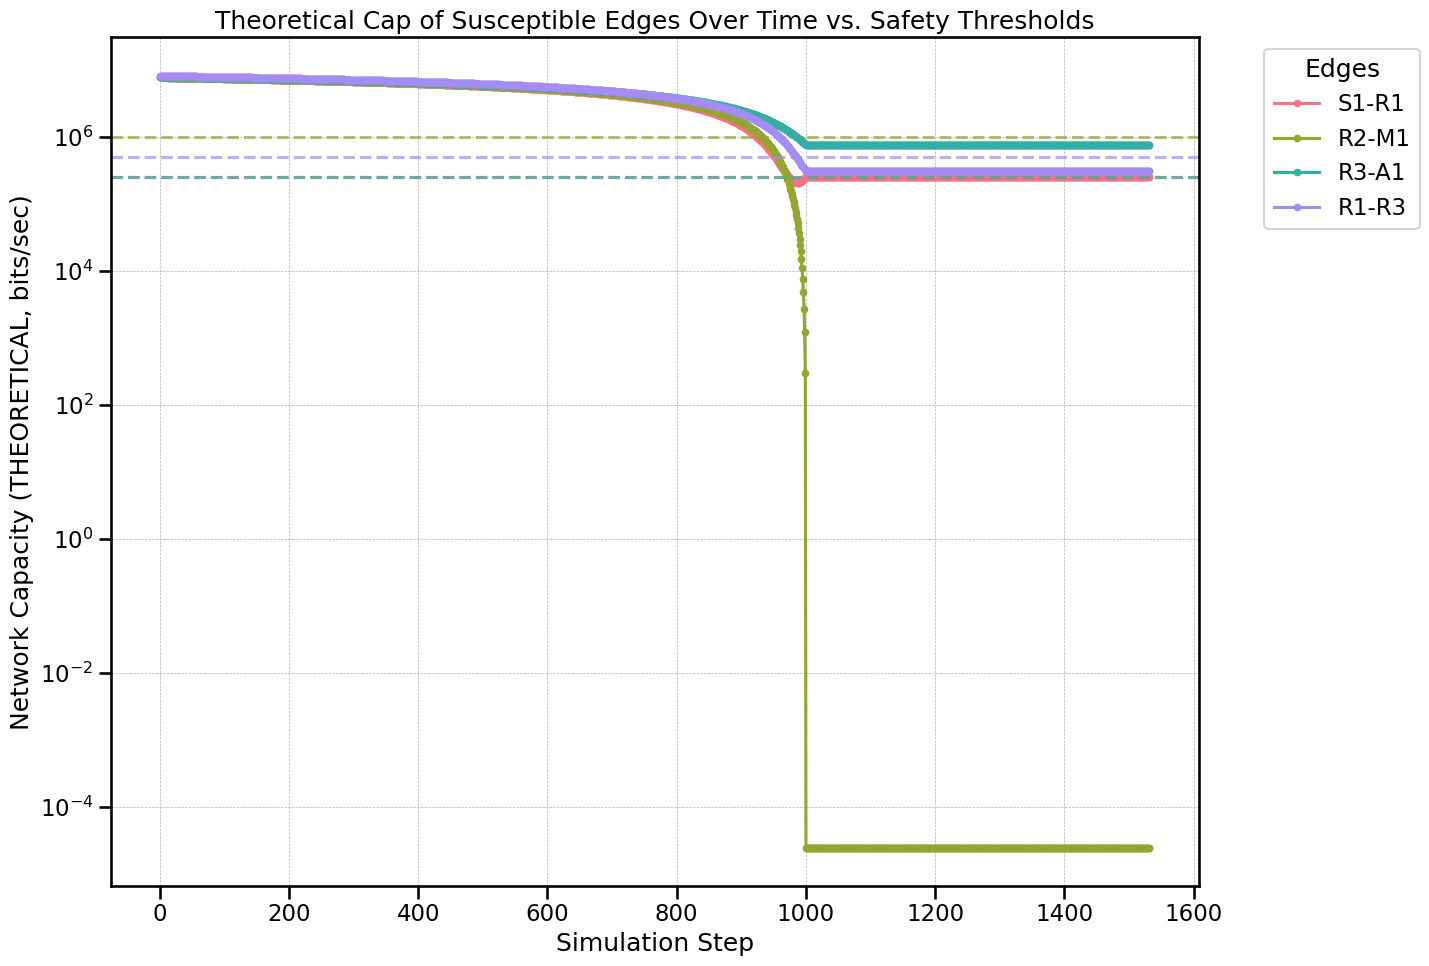

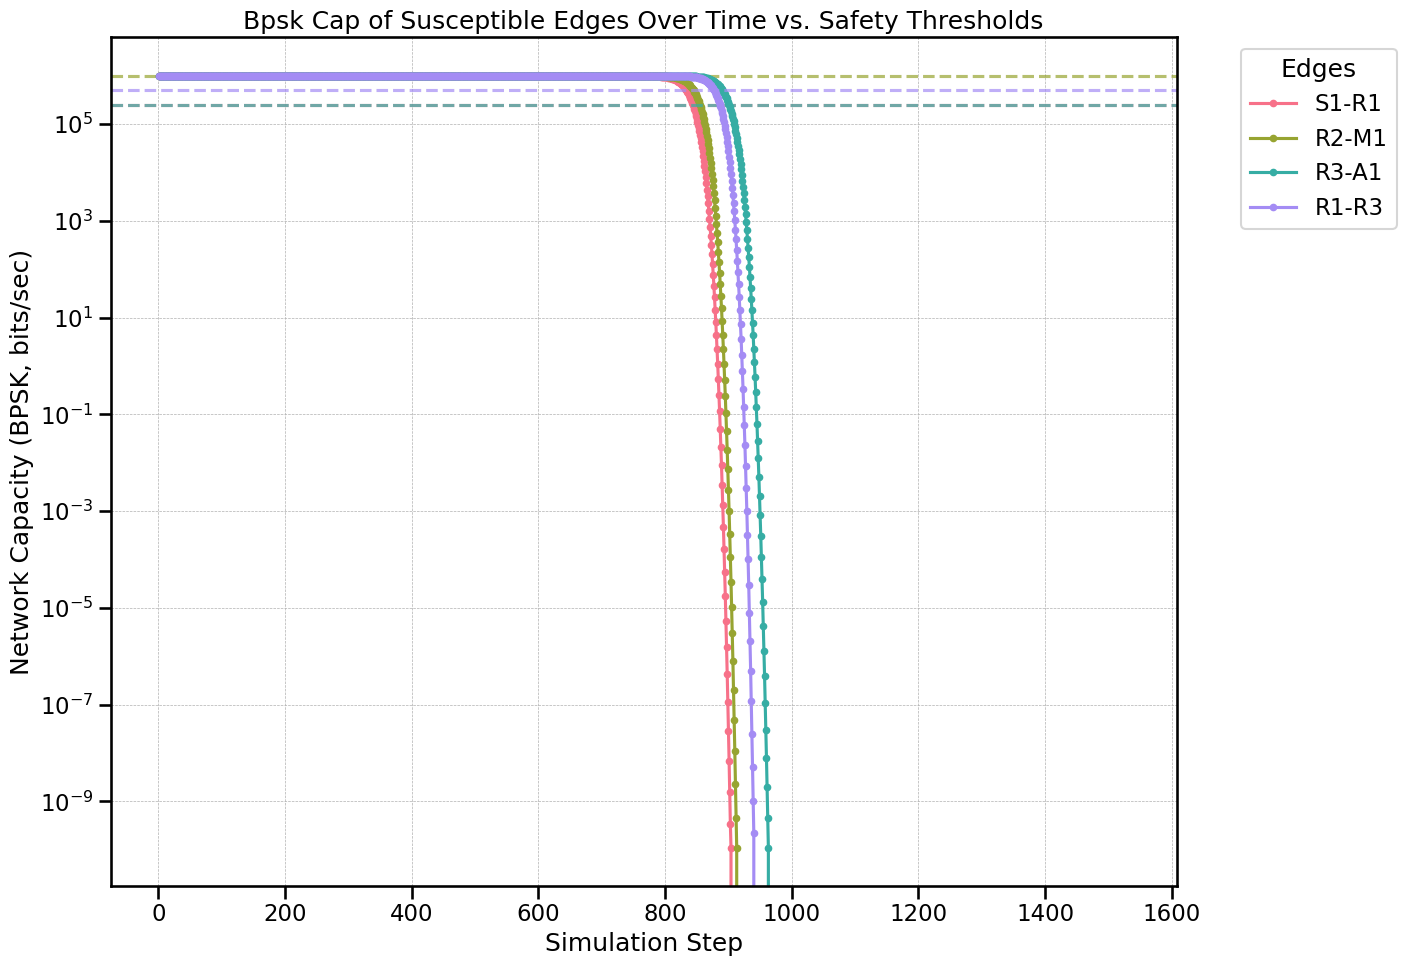

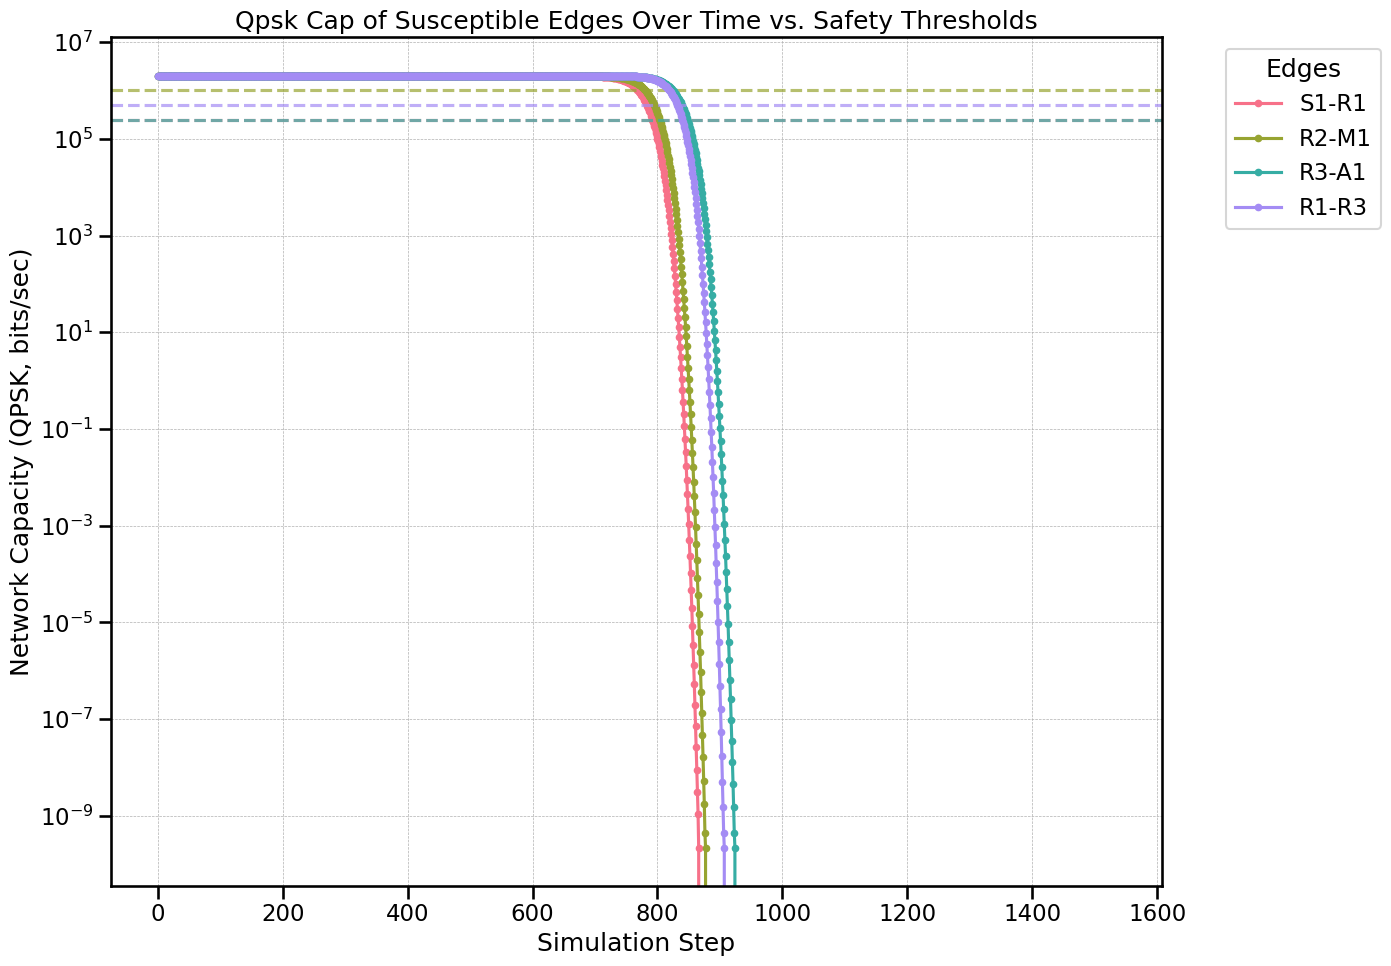

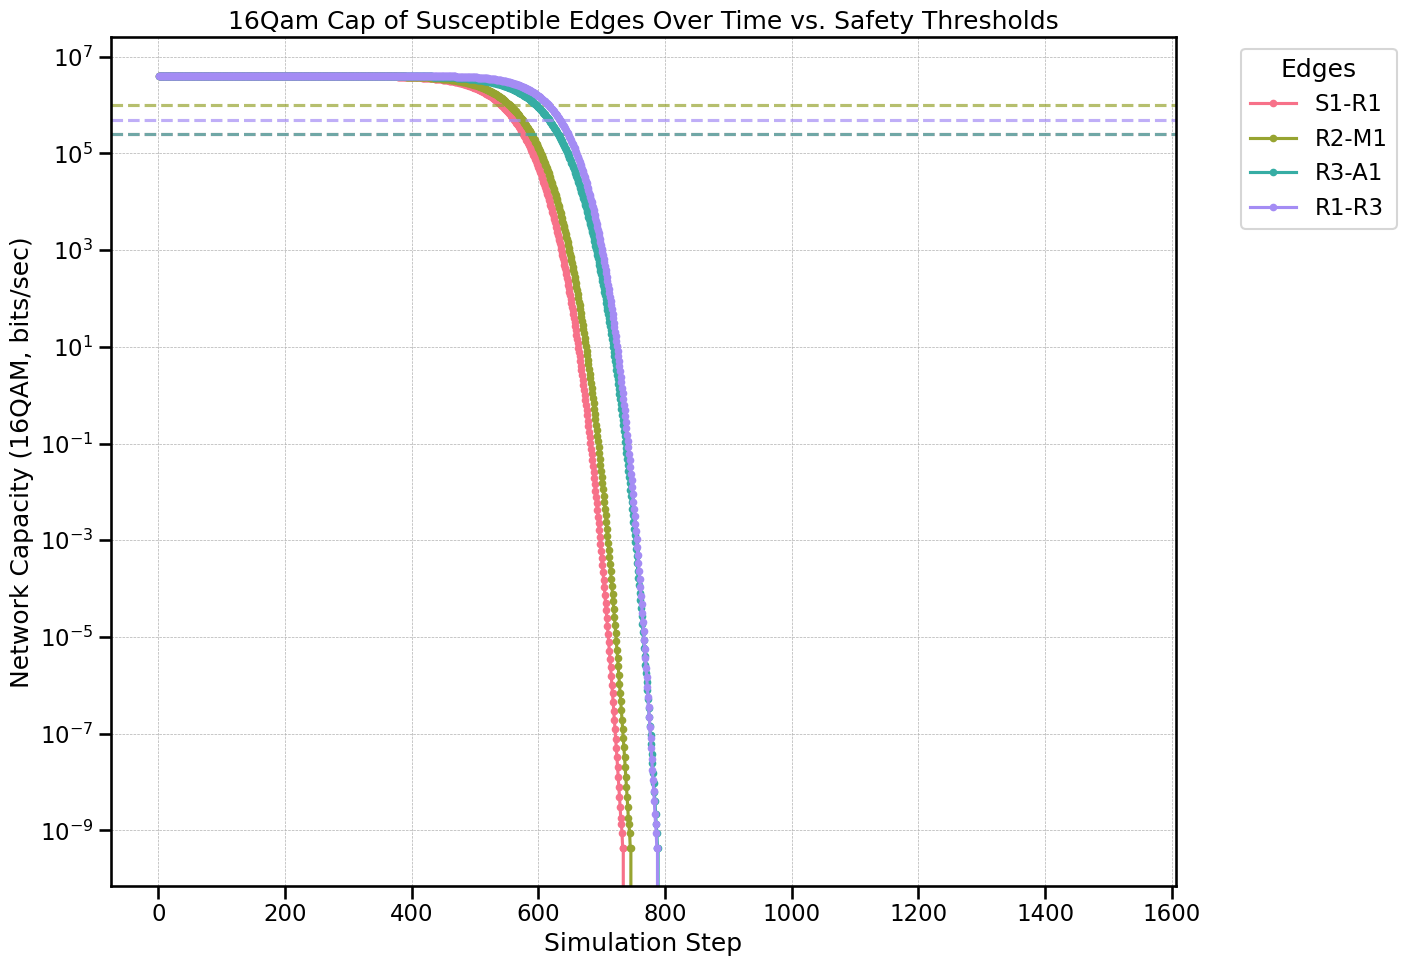

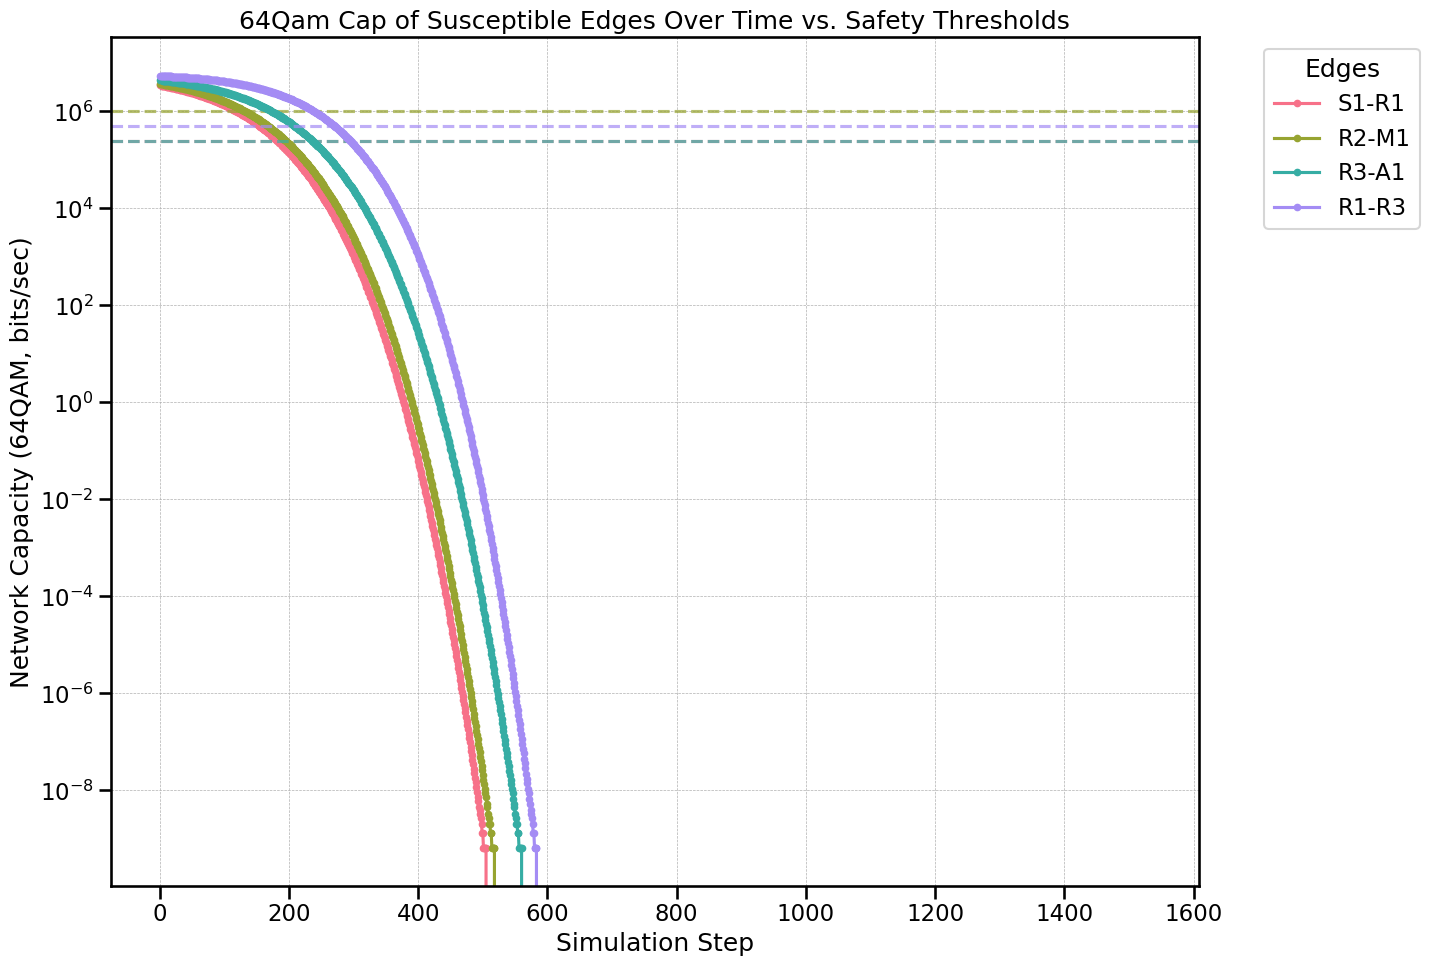

In [29]:
if 'susceptible_df' in locals() and not susceptible_df.empty and 'capacity_columns' in globals() and capacity_columns:
    unique_edges = susceptible_df['edge_label'].unique()
    palette = sns.color_palette('husl', n_colors=len(unique_edges)) # Palette based on number of unique edges

    for cap_col_name in capacity_columns: # Outer loop for each modulation type
        plt.figure(figsize=(18, 10)) # New figure for this modulation type

        for i, edge_label_str in enumerate(unique_edges): # Inner loop for each unique edge
            edge_data = susceptible_df[susceptible_df['edge_label'] == edge_label_str]

            if edge_data.empty or cap_col_name not in edge_data.columns:
                continue

            # 1. Plot capacity line for the current edge and modulation type
            # Assign label directly for the legend, using only the edge identifier.
            plt.plot(edge_data['step'], edge_data[cap_col_name], marker='.', linestyle='-',
                     color=palette[i], label=edge_label_str)
            
            # 2. Plot safety threshold line for the current edge
            # No label is assigned here, so it won't appear in the legend.
            safety_threshold_for_edge = edge_data['required_safety_capacity'].iloc[0]
            plt.axhline(y=safety_threshold_for_edge, color=palette[i], linestyle='--', alpha=0.7)

        # --- Settings for the current modulation plot (after all edges are plotted) ---
        plt.title(f'{cap_col_name.replace("_", " ").title()} of Susceptible Edges Over Time vs. Safety Thresholds')
        plt.xlabel('Simulation Step')
        plt.ylabel(f'Network Capacity ({cap_col_name.split("_")[0].upper() if "_" in cap_col_name else cap_col_name}, bits/sec)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Legend creation:
        # Get handles and labels automatically from labeled lines.
        handles, labels = plt.gca().get_legend_handles_labels()
        # Use a dictionary to ensure unique legend entries (in case of any accidental duplication)
        by_label = dict(zip(labels, handles))
        
        if by_label: # Check if there are any items for the legend
            plt.legend(by_label.values(), by_label.keys(), title='Edges', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            # Optionally, show an empty legend box or no legend if nothing was plotted with a label
            plt.legend(title='Edges', bbox_to_anchor=(1.05, 1), loc='upper left')


        plt.tight_layout(rect=[0, 0, 0.80, 1]) # Adjust layout to make space for legend
        plt.yscale('log') # Use log scale if capacities vary widely
        # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Optional: scientific notation
        
        plt.show() # Show the plot for the current modulation type

elif 'susceptible_df' in locals() and susceptible_df.empty:
    print("No susceptible edges were found in the data (is_ew_susceptible was always False).")
    print("This could mean the jammer's selected BW area did not match any edge's BW area, or no edges were marked as susceptible.")
    print("Check the 'EW_JAMMER_ACTUAL_BW_AREA' parameter, edge 'bw_area' values, and 'is_ew_susceptible' column.")
elif not ('capacity_columns' in globals() and capacity_columns):
    print("No capacity columns were identified for plotting. Please check column names in the CSV and script.")
else:
    print("No susceptible edge data to plot or 'susceptible_df' not created.")
    

### Plot each edge seperately

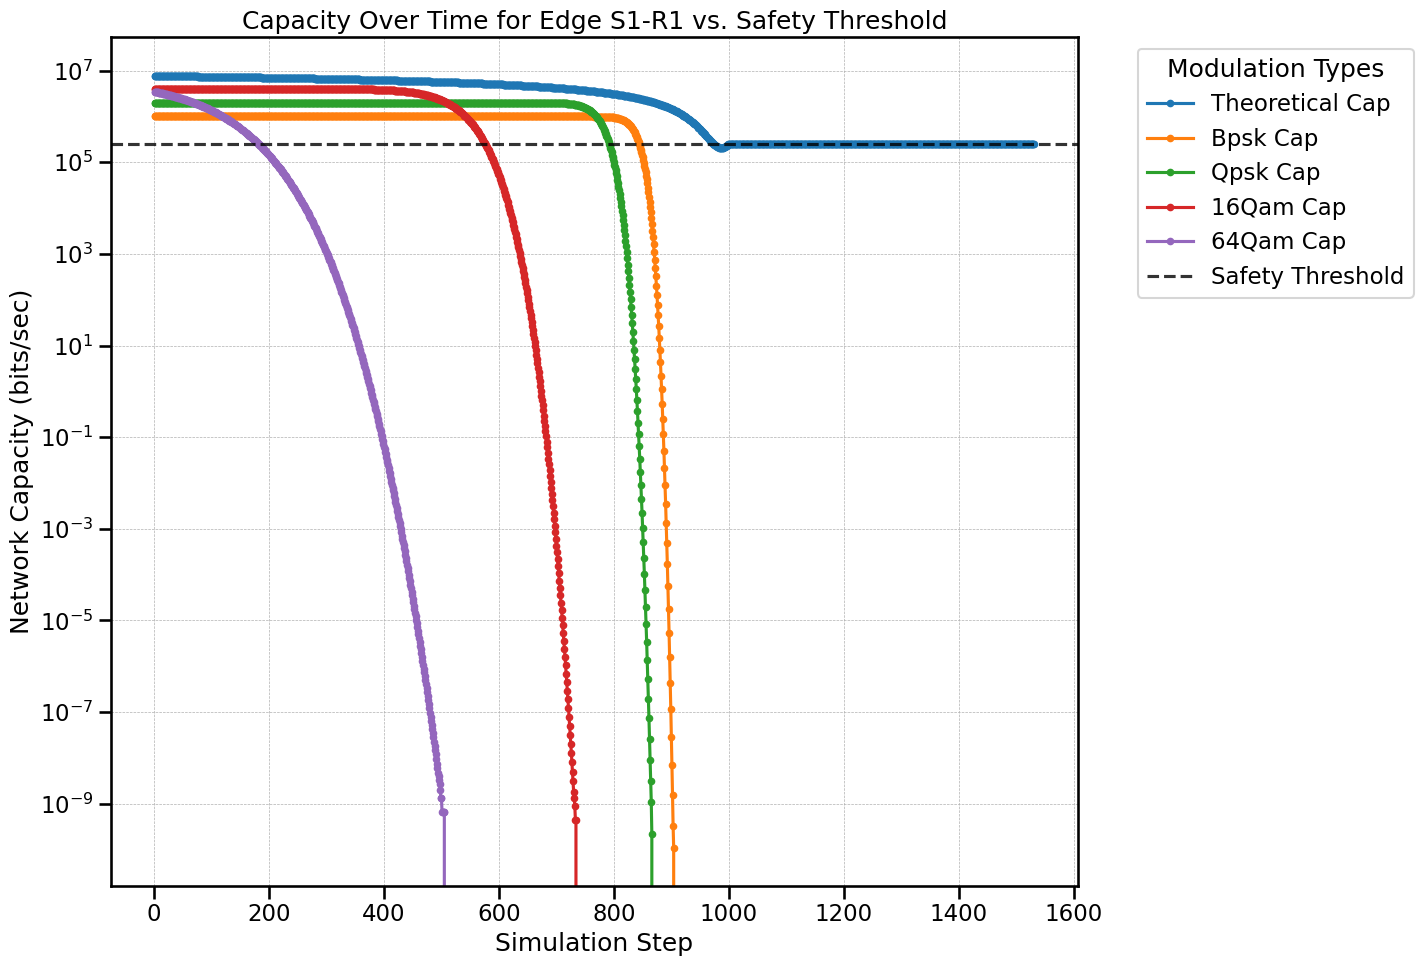

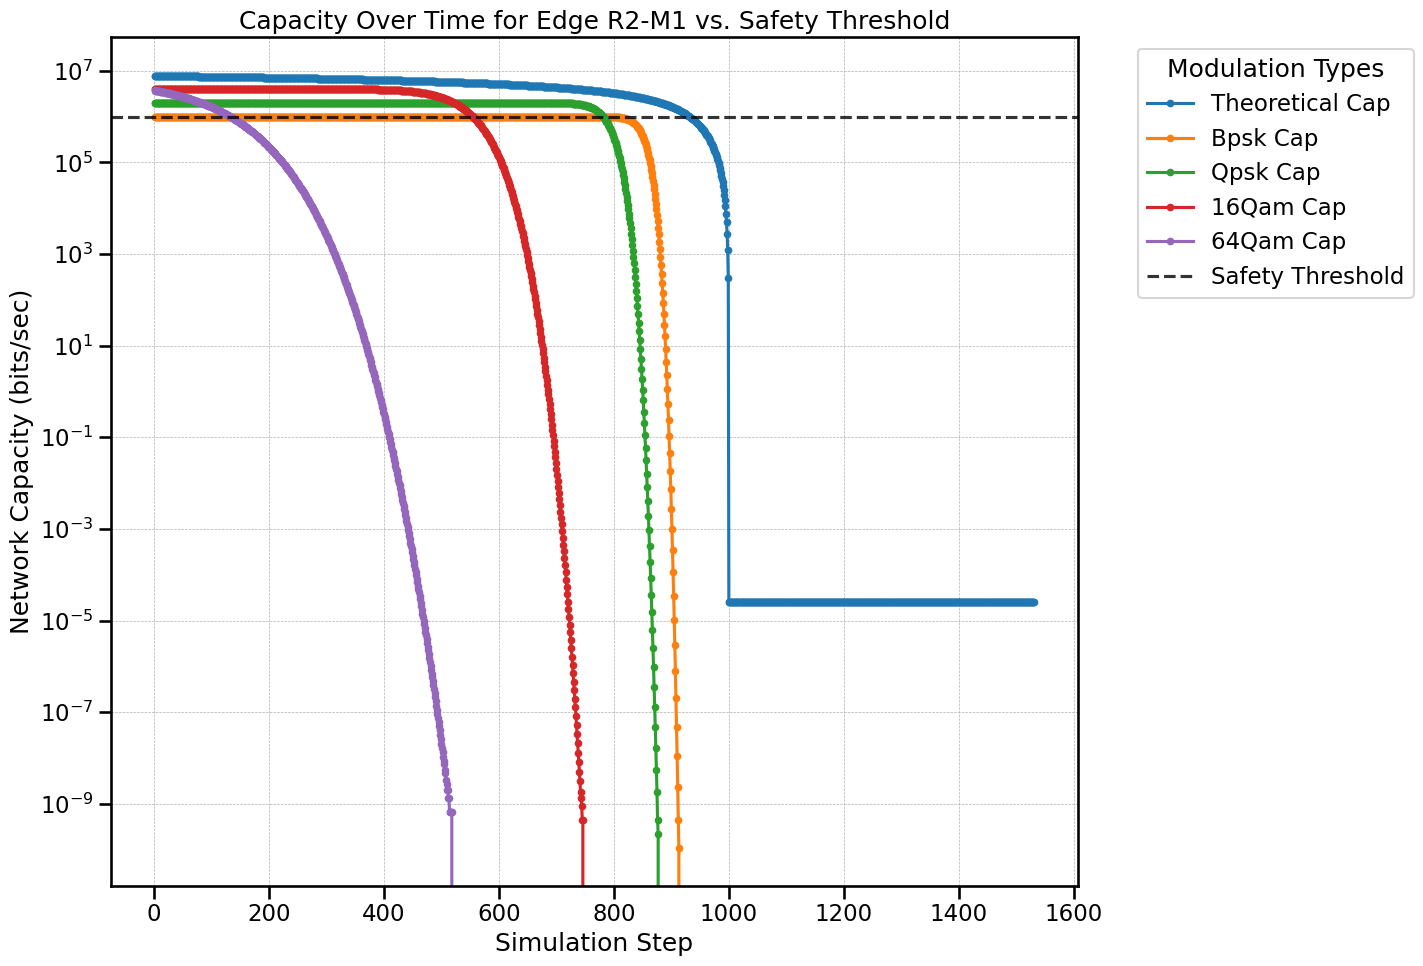

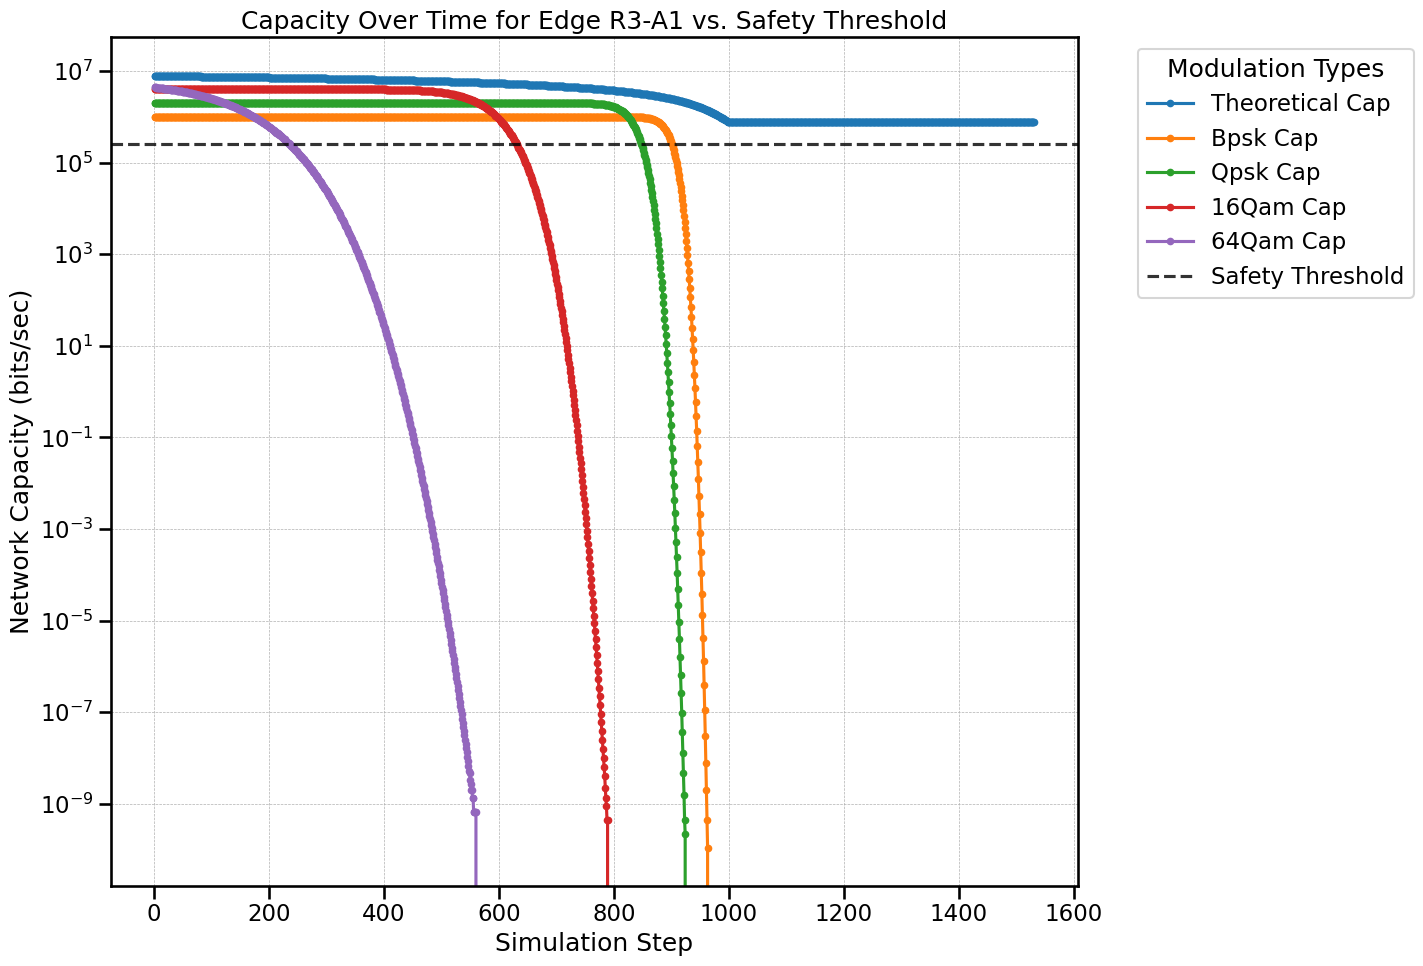

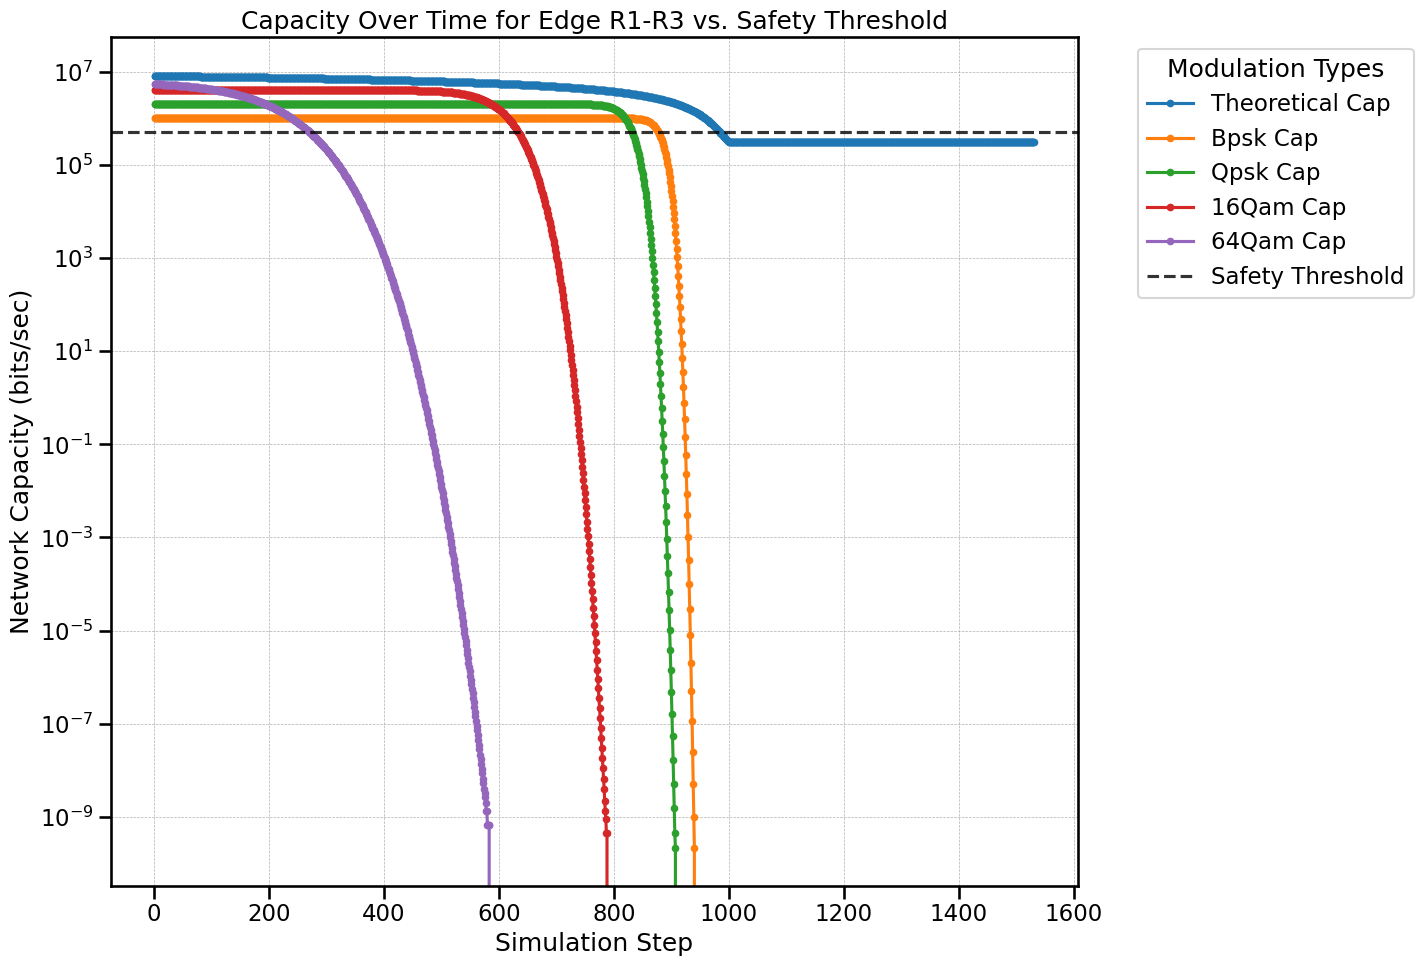

In [31]:
if 'susceptible_df' in locals() and not susceptible_df.empty and 'capacity_columns' in globals() and capacity_columns:
    unique_edges = susceptible_df['edge_label'].unique()
    palette = sns.color_palette('tab10', n_colors=len(capacity_columns))  # Color palette for modulations

    for edge_label_str in unique_edges:  # Outer loop for each unique edge
        edge_data = susceptible_df[susceptible_df['edge_label'] == edge_label_str]

        if edge_data.empty:
            continue

        plt.figure(figsize=(18, 10))  # New figure for each edge

        for i, cap_col_name in enumerate(capacity_columns):  # Inner loop for each modulation type
            if cap_col_name not in edge_data.columns:
                continue

            # 1. Plot capacity line for the current modulation type
            plt.plot(edge_data['step'], edge_data[cap_col_name], marker='.', linestyle='-',
                     color=palette[i], label=cap_col_name.replace('_', ' ').title())

        # 2. Plot safety threshold line for the current edge (only one, independent of modulation)
        safety_threshold = edge_data['required_safety_capacity'].iloc[0]
        plt.axhline(y=safety_threshold, color='black', linestyle='--', alpha=0.8, label='Safety Threshold')

        # --- Settings for the current edge plot ---
        plt.title(f'Capacity Over Time for Edge {edge_label_str} vs. Safety Threshold')
        plt.xlabel('Simulation Step')
        plt.ylabel('Network Capacity (bits/sec)')
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(title='Modulation Types', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.80, 1])
        plt.yscale('log')  # Optional depending on data spread
        plt.show()

elif 'susceptible_df' in locals() and susceptible_df.empty:
    print("No susceptible edges were found in the data (is_ew_susceptible was always False).")
    print("This could mean the jammer's selected BW area did not match any edge's BW area, or no edges were marked as susceptible.")
    print("Check the 'EW_JAMMER_ACTUAL_BW_AREA' parameter, edge 'bw_area' values, and 'is_ew_susceptible' column.")
elif not ('capacity_columns' in globals() and capacity_columns):
    print("No capacity columns were identified for plotting. Please check column names in the CSV and script.")
else:
    print("No susceptible edge data to plot or 'susceptible_df' not created.")
